In [ ]:
!pip install scrapy
!pip install requests
!pip install selenium
import numpy as np
import pandas as pd
import scrapy
import matplotlib.pyplot as plt
import requests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
import pmdarima as pm
!pip install plotly
import plotly.graph_objs as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
# !pip install -U keras-tuner
# import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
!pip install arch
from arch import arch_model


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 6.8 MB/s eta 0:00:00


## PE Ratio

In [ ]:
# Fetch the data
url = 'https://www.macrotrends.net/stocks/charts/GOOGL/alphabet/pe-ratio'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36'}

response = requests.get(url, headers=headers)
response.raise_for_status()
data = pd.read_html(response.text, skiprows=1)
df = pd.DataFrame(data[0])
df = pd.concat([df.columns.to_frame().T, df], ignore_index=True)
df.columns = range(len(df.columns))
df = df[1:]
df = df.rename(columns={0: 'Date', 1: 'Price', 2: 'EPS', 3: 'PE ratio'})
df.set_index('Date', inplace=True)
df = df.iloc[1:, :]
df['PE ratio'] = df['PE ratio'].astype(float)
df.index = pd.to_datetime(df.index)
df = df.sort_index().reset_index()
l = len(df['EPS'])
df.head()

,Date,Price,EPS,PE ratio
0,2009-12-31,15.53,$0.51,30.40
1,2010-03-31,14.21,$0.55,25.83
2,2010-06-30,11.15,$0.58,19.33
3,2010-09-30,13.17,$0.62,21.38
4,2010-12-31,14.88,$0.66,22.61


                                Date   PE ratio
count                             58  58.000000
mean   2017-02-13 11:35:10.344827648  27.015690
min              2009-12-31 00:00:00  16.710000
25%              2013-07-23 00:00:00  22.025000
50%              2017-02-14 00:00:00  25.430000
75%              2020-09-07 00:00:00  29.735000
max              2024-03-31 00:00:00  58.590000
std                              NaN   7.791575


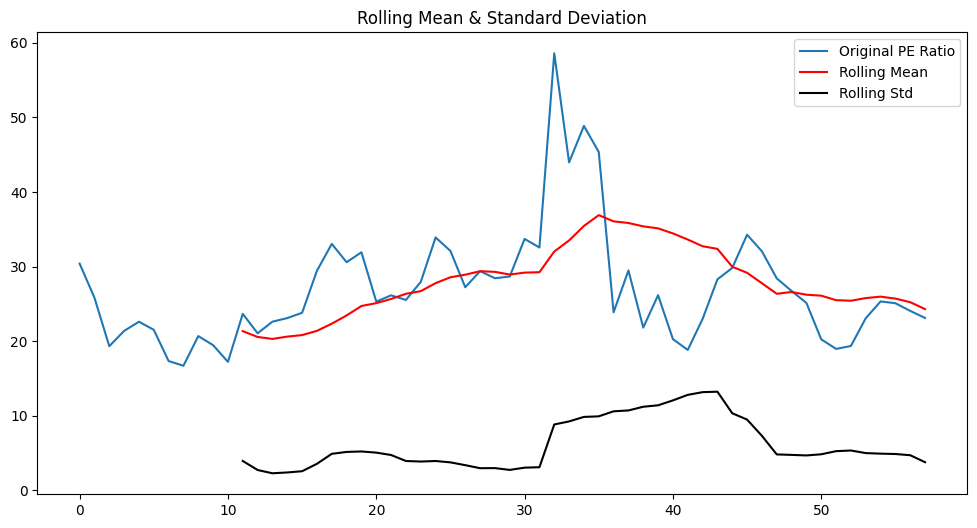

In [ ]:
# EDA
# 1. Statistical Summary
df_summary = df.describe()
print(df_summary)

# 4. Rolling Statistics
rolling_window = 12

plt.figure(figsize=(12, 6))
rolling_mean = df['PE ratio'].rolling(window=rolling_window).mean()
rolling_std = df['PE ratio'].rolling(window=rolling_window).std()

plt.plot(df['PE ratio'], label='Original PE Ratio')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

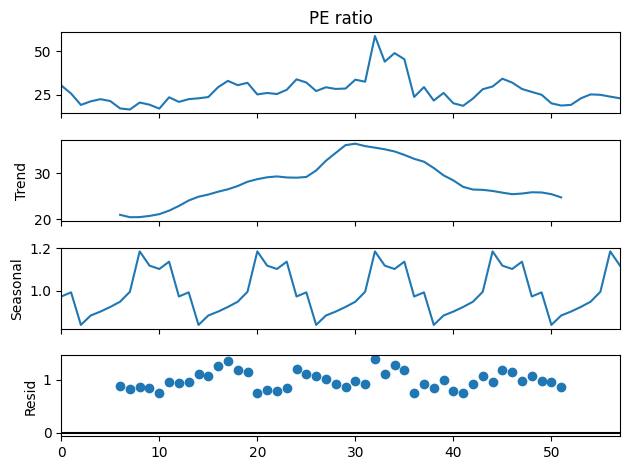

In [ ]:
# 5. Decomposition of Time Series
result = seasonal_decompose(df['PE ratio'], model='multiplicative', period=12)
result.plot()
plt.show()

In [ ]:
# Check for stationarity
result = adfuller(df['PE ratio'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')


ADF Statistic: -2.273479293620896
p-value: 0.18066411992193482
Critical Values 1%: -3.560242358792829
Critical Values 5%: -2.9178502070837
Critical Values 10%: -2.5967964150943397


In [ ]:
# Difference the series to make it stationary
df['PE ratio diff'] = df['PE ratio'].diff().dropna()
result = adfuller(df['PE ratio diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -4.679205215478182
p-value: 9.205689179093706e-05
Critical Values 1%: -3.560242358792829
Critical Values 5%: -2.9178502070837
Critical Values 10%: -2.5967964150943397


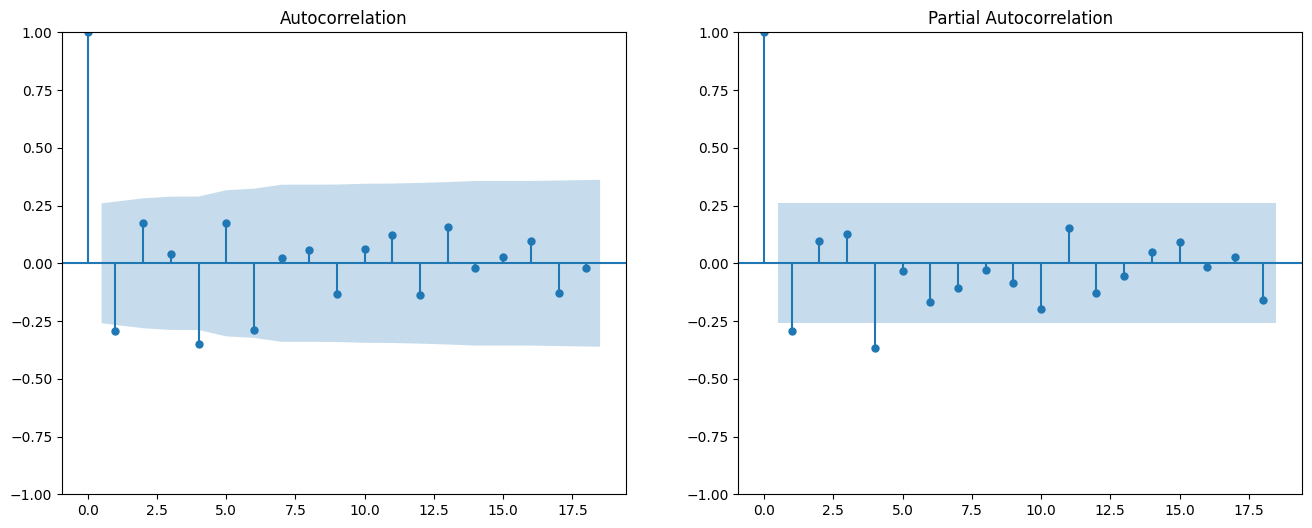

In [ ]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['PE ratio diff'].dropna(), ax=axes[0])
plot_pacf(df['PE ratio diff'].dropna(), ax=axes[1])
plt.show()

In [ ]:
# Train Test split
train_size = len(df) - 10
train, test = df[:train_size], df[train_size:]

In [ ]:
# Fit ARIMA model using pmdarima for automatic selection
ARIMA_model = pm.auto_arima(train['PE ratio'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

ARIMA_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=461.497, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=322.193, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=319.444, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=321.312, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=320.443, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=313.537, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=313.387, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=341.953, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=314.288, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=326.265, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=315.169, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.704 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -153.694
Date:                Thu, 18 Jul 2024   AIC                            313.387
Time:                        14:58:21   BIC                            319.001
Sample:                             0   HQIC                           315.509
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.9907      3.875      2.320      0.020       1.396      16.586
ar.L1          0.6784      0.109      6.233      0.000       0.465       0.892
sigma2        34.9307      3.771      9.262      0.000      27.539      42.323
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):               163.58
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               6.66   Skew:                             1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Best model ARIMA(1,0,0)

> Add blockquote



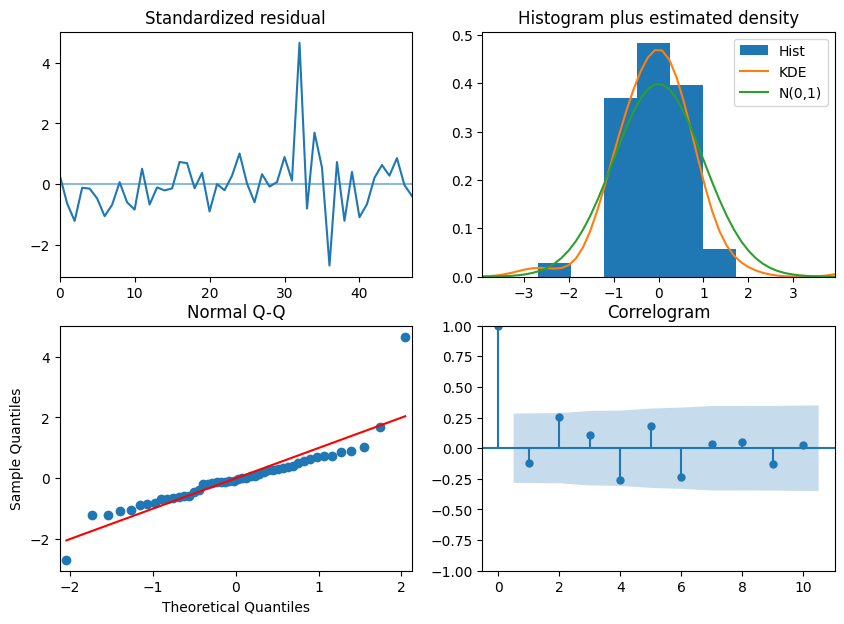

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

In [ ]:
# Ljung-Box test
ARIMA_model = SARIMAX(train['PE ratio'], order=(1,0,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,3.659345,0.055756
2,3.786955,0.150547
3,3.911759,0.271152
4,6.886521,0.142008
5,7.756443,0.170179
6,10.993455,0.088579
7,11.018306,0.137823
8,11.358325,0.182211
9,12.245896,0.199799
10,12.250464,0.268644


### Residuals are observed values of iid RVs

In [ ]:
# Predictions of last 10 months
ARIMA_pred = ARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

<ipython-input-14-5c1591380097>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


In [ ]:
# Differencing the data seasonally
df_diff2 = np.diff(df['PE ratio'], n=4)
result = adfuller(df_diff2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -4.342191729328323
p-value: 0.00037513376535809964
Critical Values 1%: -3.596635636000432
Critical Values 5%: -2.933297331821618
Critical Values 10%: -2.6049909750566895


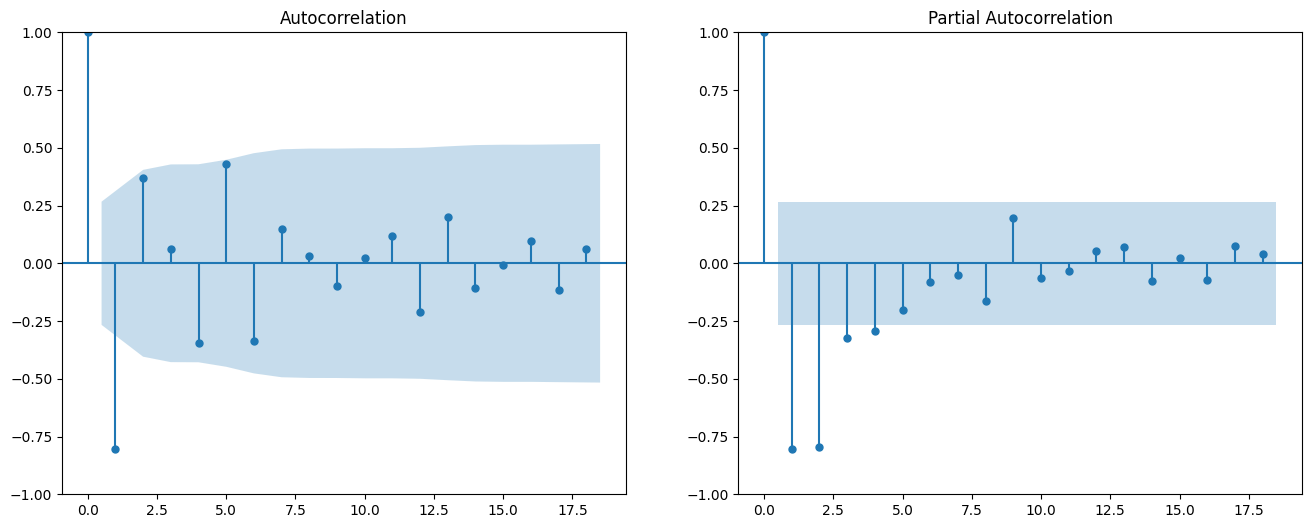

In [ ]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(pd.DataFrame(df_diff2).dropna(), ax=axes[0])
plot_pacf(pd.DataFrame(df_diff2).dropna(), ax=axes[1])
plt.show()

In [ ]:
SARIMA_model = pm.auto_arima(train["PE ratio"], start_p=1, start_q=1,
                         test='kpss',
                         max_p=5, max_q=5,
                         m=4, #12 is the frequncy of the cycle
                         start_P=1, start_Q=1,
                         max_P = 5, max_Q=5,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=None,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
SARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=341.953, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=311.401, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=328.241, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=461.497, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=313.387, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=313.259, Time=0.77 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=312.540, Time=0.85 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=310.772, Time=0.34 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=312.651, Time=0.47 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=314.227, Time=0.76 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=343.156, Time=0.09 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=309.998, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=313.537, Time=0.15 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept   : AIC=311.929, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 4)   Log Likelihood                -149.999
Date:                             Thu, 18 Jul 2024   AIC                            309.998
Time:                                     14:59:55   BIC                            319.354
Sample:                                          0   HQIC                           313.534
                                              - 48                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.7033      4.628      1.016      0.310      -4.368      13.774
ar.L1          0.5969      0.238      2.512      0.012       0.131       1.063
ar.L2          0.2350      0.206      1.138      0.255      -0.170       0.640
ma.S.L4       -0.3921      0.167     -2.345      0.019      -0.720      -0.064
sigma2        29.5713      3.321      8.904      0.000      23.062      36.081
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               277.97
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               4.23   Skew:                             2.34
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Best Model ARIMA(2,0,0)(0,0,1)[4]

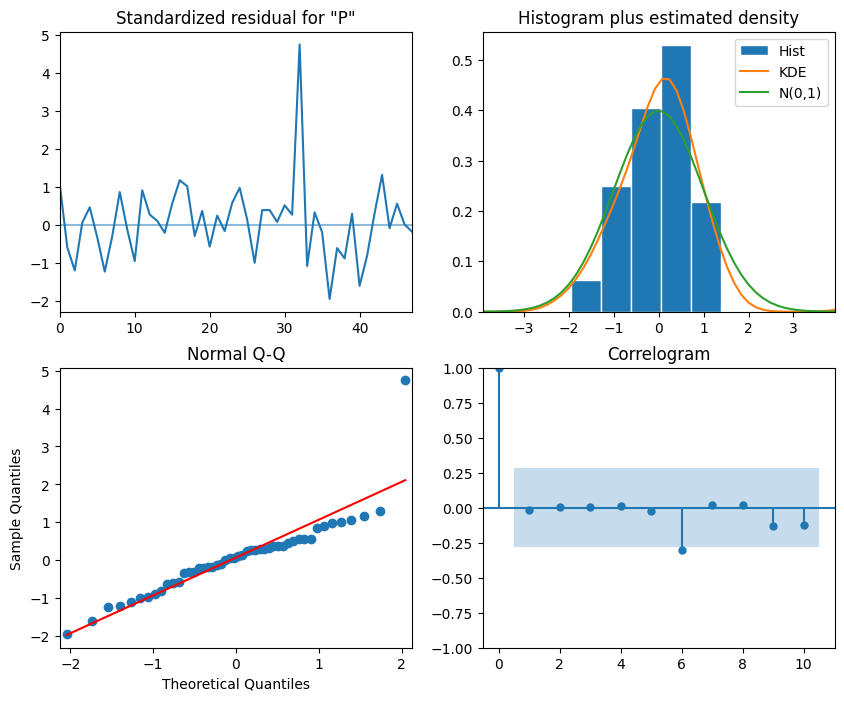

In [ ]:
SARIMA_model = SARIMAX(train["PE ratio"], order=(2,0,0), seasonal_order=(0,0,1,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.125526,0.723116
2,0.470463,0.790388
3,0.470651,0.925290
4,0.535877,0.969916
5,0.618587,0.987136
6,4.793009,0.570622
7,4.799957,0.684360
8,4.985348,0.759141
9,5.602138,0.778982
10,6.936338,0.731441


### Residuals are observed values if IID RVs

In [ ]:
# Predicting last 10 PEs of the data
SARIMA_pred = SARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

<ipython-input-21-dbe47345b5e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


In [ ]:
# Fit GARCH model to the training set
garch_model = arch_model(train['PE ratio'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

In [ ]:
# Forecast using the GARCH model
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_pred = garch_forecast.mean.iloc[-1].values
test['GARCH_pred'] = garch_pred

<ipython-input-23-a0d20fe8156c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GARCH_pred'] = garch_pred


In [ ]:
# Fit ARMA model using pmdarima for automatic selection
arma_model = pm.auto_arima(train['PE ratio'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

arma_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=461.497, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=322.193, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=319.444, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=321.312, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=320.443, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=313.537, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=313.387, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=341.953, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=314.288, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=326.265, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=315.169, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.617 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -153.694
Date:                Thu, 18 Jul 2024   AIC                            313.387
Time:                        15:01:11   BIC                            319.001
Sample:                             0   HQIC                           315.509
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.9907      3.875      2.320      0.020       1.396      16.586
ar.L1          0.6784      0.109      6.233      0.000       0.465       0.892
sigma2        34.9307      3.771      9.262      0.000      27.539      42.323
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):               163.58
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               6.66   Skew:                             1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Get residuals from the ARMA model
residuals = arma_model.resid()

# Fit GARCH model to the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Forecast ARMA model
n_forecast = len(test)
arma_forecast, conf_int = arma_model.predict(n_periods=n_forecast, return_conf_int=True)

# Forecast GARCH model
garch_forecast = garch_fit.forecast(horizon=n_forecast)
garch_pred = garch_forecast.mean.iloc[-1].values

# Combine ARMA and GARCH forecasts
test['ARMA_GARCH_pred'] = arma_forecast + garch_pred

<ipython-input-25-e6f4f7f3b7e7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARMA_GARCH_pred'] = arma_forecast + garch_pred


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['PE ratio']])
test_scaled = scaler.transform(test[['PE ratio']])
test1 = df[-15:]
test1_scaled = scaler.transform(test1[['PE ratio']])

In [ ]:
# Create the dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 5
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)
X_test1, y_test1 = create_dataset(test1_scaled, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, 1)
X_test = X_test.reshape(X_test.shape[0], time_step, 1)
X_test1 = X_test1.reshape(X_test1.shape[0], time_step, 1)

In [ ]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
43/43 [==============================] - 7s 8ms/step - loss: 0.0513
Epoch 2/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0439
Epoch 3/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0364
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0376
Epoch 5/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0363
Epoch 6/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0348
Epoch 7/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0326
Epoch 8/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0346
Epoch 9/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0359
Epoch 10/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0311
Epoch 11/100
43/43 [==============================] - 0s 9ms/step - loss: 0.0329
Epoch 12/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0322
Epoch 13/100
43/43 [=================

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test1)
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

1/1 [==============================] - 0s 21ms/step


In [ ]:
test['LSTM_pred'] = test_predict[:, 0]

<ipython-input-31-feca5b1a0150>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM_pred'] = test_predict[:, 0]


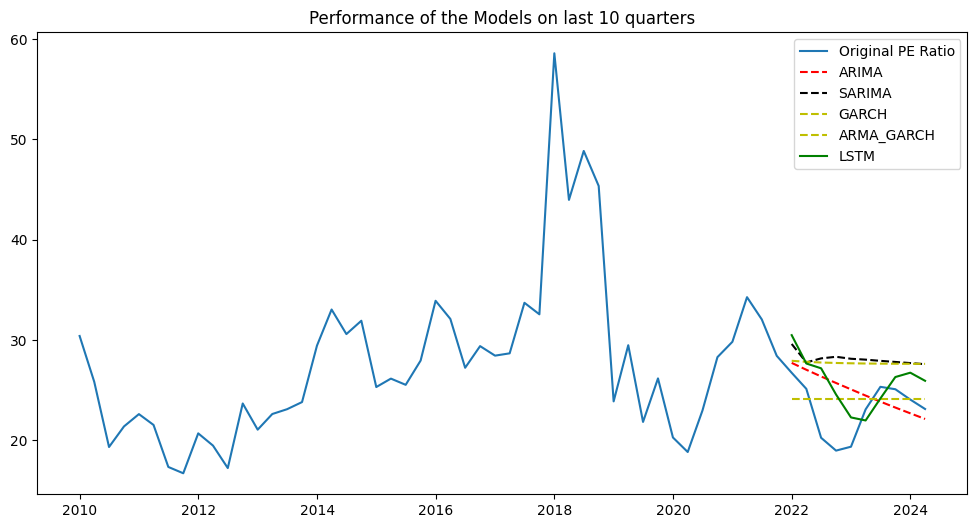

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'],df['PE ratio'], label='Original PE Ratio')
plt.plot(df['Date'][-10:], test['ARIMA_pred'], 'r--', label='ARIMA')
plt.plot(df['Date'][-10:], test['SARIMA_pred'],  'k--', label='SARIMA')
plt.plot(df['Date'][-10:], test['GARCH_pred'],  'y--', label='GARCH')
plt.plot(df['Date'][-10:], test['ARMA_GARCH_pred'],  'y--', label='ARMA_GARCH')
plt.plot(df['Date'][-10:], test['LSTM_pred'],  color = 'green', label='LSTM')
plt.title('Performance of the Models on last 10 quarters')
plt.legend()
plt.show()

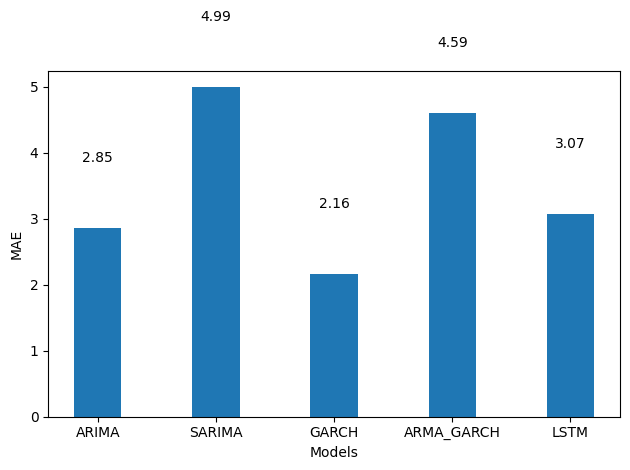

In [ ]:
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)))

mae_ARIMA = mae(test['PE ratio'], test['ARIMA_pred'])
mae_SARIMA = mae(test['PE ratio'], test['SARIMA_pred'])
mae_GARCH = mae(test['PE ratio'], test['GARCH_pred'])
mae_ARMA_GARCH = mae(test['PE ratio'], test['ARMA_GARCH_pred'])
mae_LSTM = mae(test['PE ratio'], test['LSTM_pred'])

fig, ax = plt.subplots()

x = ['ARIMA', 'SARIMA', 'GARCH', 'ARMA_GARCH', 'LSTM']
y = [mae_ARIMA, mae_SARIMA, mae_GARCH, mae_ARMA_GARCH, mae_LSTM]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()

1/1 [==============================] - 0s 36ms/step
Forecasted PE Ratios for the next 20 quarters:
[30.484316 29.296738 30.405535 31.016691 31.350641 31.96253  32.07289
 32.22249  32.20285  32.090508 31.993504 31.868393 31.7911   31.744864
 31.729063 31.741571 31.76343  31.790623 31.814005 31.830147]


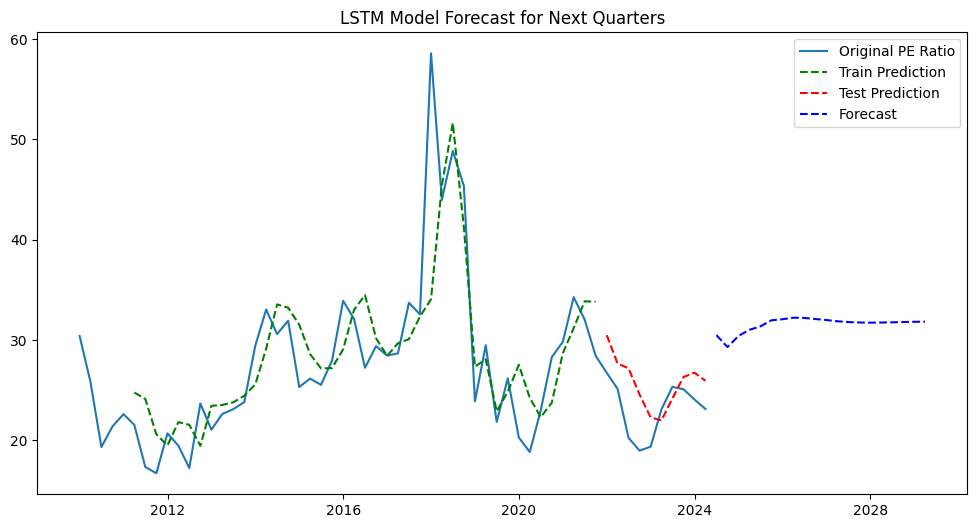

In [ ]:
# Forecasting the next n_steps quarters
n_steps = 20 # Number of steps to forecast
last_time_steps = train_scaled[-time_step:]  # Use the last time_step values from training set

forecasts = []
for i in range(n_steps):
    next_pred = model.predict(last_time_steps.reshape(1, time_step, 1))
    forecasts.append(next_pred[0, 0])
    last_time_steps = np.roll(last_time_steps, -1)
    last_time_steps[-1] = next_pred

# Invert forecasts to original scale
forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Print and plot forecasts
print("Forecasted PE Ratios for the next", n_steps, "quarters:")
print(forecasts.flatten())

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['PE ratio'], label='Original PE Ratio')
plt.plot(df['Date'][time_step:train_size], train_predict, 'g--', label='Train Prediction')
plt.plot(df['Date'][-10:], test_predict, 'r--', label='Test Prediction')
plt.plot(pd.date_range(df['Date'].iloc[-1], periods=n_steps+1, freq='Q')[1:], forecasts, 'b--', label='Forecast')
plt.title('LSTM Model Forecast for Next Quarters')
plt.legend()
plt.show()

# ROE

In [ ]:
url = 'https://www.macrotrends.net/stocks/charts/GOOGL/alphabet/roe'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36'}

response = requests.get(url, headers=headers)
response.raise_for_status()  # Ensure we notice bad responses
data = pd.read_html(response.text, skiprows=1)
df = pd.DataFrame(data[0])
df = pd.concat([df.columns.to_frame().T, df], ignore_index=True)
df.columns = range(len(df.columns))
df = df.rename(columns={0 : 'Date', 1 : 'TTMNI', 2 : 'SE', 3 : 'ROE'})
df.set_index('Date', inplace = True)
df = df.iloc[1:, :]
df['ROE'] = df['ROE'].str.replace('%', '').astype(float)
df.index = pd.to_datetime(df.index)
df = df.sort_index().reset_index()
l = len(df['ROE'])
df.head(5)

,Date,TTMNI,SE,ROE
0,2009-12-31,$6.52B,$36.00B,19.88
1,2010-03-31,$7.05B,$38.28B,20.21
2,2010-06-30,$7.41B,$40.61B,19.94
3,2010-09-30,$7.94B,$43.29B,20.06
4,2010-12-31,$8.51B,$46.24B,20.20


                                Date        ROE
count                             58  58.000000
mean   2017-02-13 11:35:10.344827648  18.512931
min              2009-12-31 00:00:00   8.400000
25%              2013-07-23 00:00:00  14.767500
50%              2017-02-14 00:00:00  17.435000
75%              2020-09-07 00:00:00  20.165000
max              2024-03-31 00:00:00  31.560000
std                              NaN   5.372903


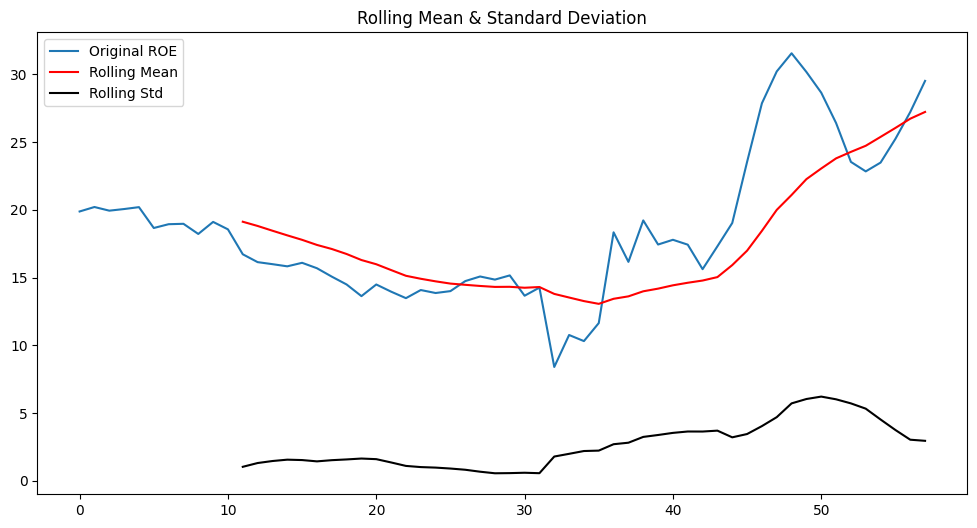

In [ ]:
# EDA

# 1. Statistical Summary
df_summary = df.describe()
print(df_summary)

# 4. Rolling Statistics
rolling_window = 12

plt.figure(figsize=(12, 6))
rolling_mean = df['ROE'].rolling(window=rolling_window).mean()
rolling_std = df['ROE'].rolling(window=rolling_window).std()

plt.plot(df['ROE'], label='Original ROE')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

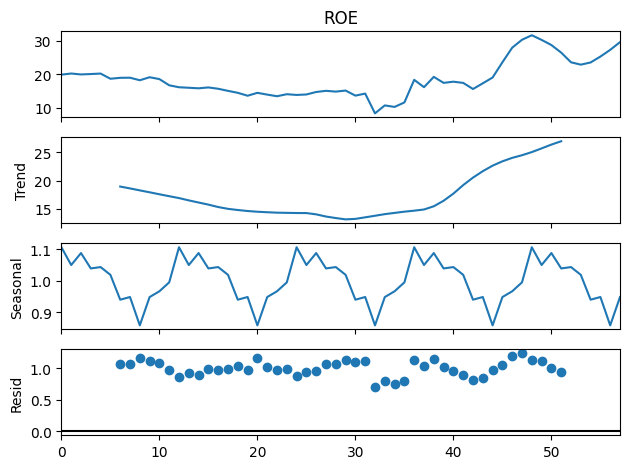

In [ ]:
# 5. Decomposition of Time Series
result = seasonal_decompose(df['ROE'], model='multiplicative', period=12)
result.plot()
plt.show()

In [ ]:
# Check for stationarity
result = adfuller(df['ROE'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -3.070159376643748
p-value: 0.02884180111217812
Critical Values 1%: -3.5812576580093696
Critical Values 5%: -2.9267849124681518
Critical Values 10%: -2.6015409829867675


In [ ]:
# # Difference the series to make it stationary
# df['ROE diff'] = df['ROE'].diff().dropna()
# result = adfuller(df['ROE diff'].dropna())
# print('ADF Statistic:', result[0])
# print('p-value:', result[1])
# for key, value in result[4].items():
#     print(f'Critical Values {key}: {value}')

ADF Statistic: -2.1176004337957703
p-value: 0.23749652393201537
Critical Values 1%: -3.5656240522121956
Critical Values 5%: -2.920142229157715
Critical Values 10%: -2.598014675124952


In [ ]:
# # Difference the series to make it stationary
# df['ROE diff'] = df['ROE diff'].diff().dropna()
# result = adfuller(df['ROE diff'].dropna())
# print('ADF Statistic:', result[0])
# print('p-value:', result[1])
# for key, value in result[4].items():
#     print(f'Critical Values {key}: {value}')

ADF Statistic: -6.203313199933484
p-value: 5.737029897436829e-08
Critical Values 1%: -3.5656240522121956
Critical Values 5%: -2.920142229157715
Critical Values 10%: -2.598014675124952


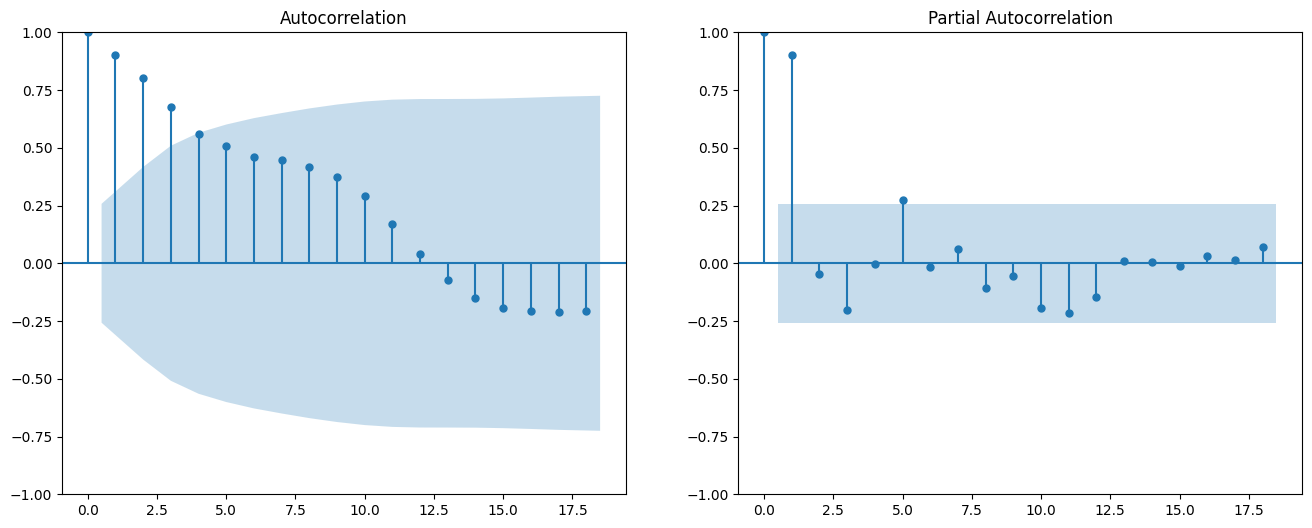

In [ ]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['ROE'].dropna(), ax=axes[0])
plot_pacf(df['ROE'].dropna(), ax=axes[1])
plt.show()

In [ ]:
# Train Test split
train_size = len(df) - 10
train, test = df[:train_size], df[train_size:]

In [ ]:
# Fit ARIMA model using pmdarima for automatic selection
ARIMA_model = pm.auto_arima(train['ROE'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

ARIMA_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=411.401, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=209.814, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=326.609, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=207.834, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=237.357, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=205.848, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=270.051, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=207.823, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=209.596, Time=0.34 sec

Best 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -99.924
Date:                Thu, 18 Jul 2024   AIC                            205.848
Time:                        15:05:46   BIC                            211.462
Sample:                             0   HQIC                           207.970
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1482      0.915      1.255      0.209      -0.645       2.941
ar.L1          0.9430      0.053     17.869      0.000       0.840       1.046
sigma2         3.5958      0.461      7.804      0.000       2.693       4.499
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                26.35
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):              17.40   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Best Model ARIMA(1, 0, 0)

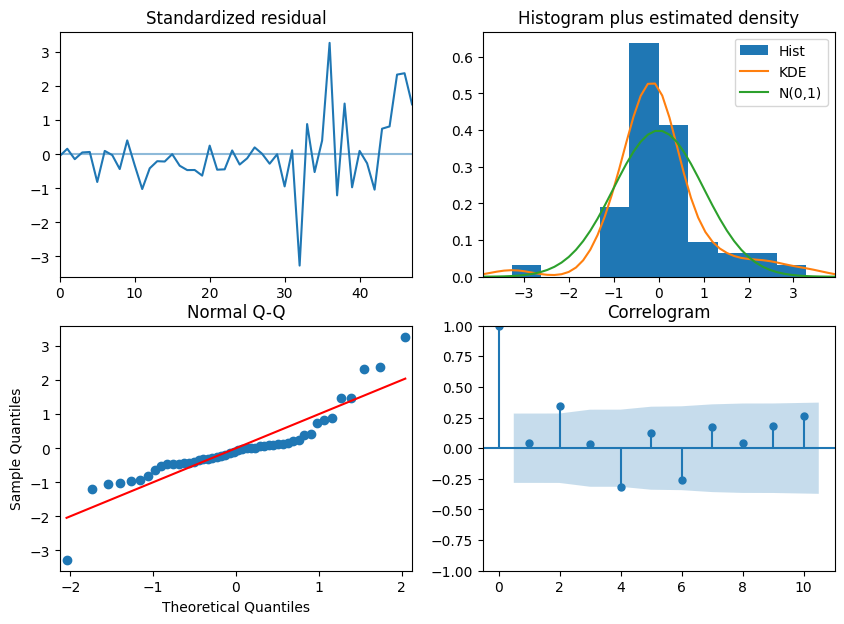

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

In [ ]:
# Ljung-Box test
ARIMA_model = SARIMAX(train['ROE'], order=(1,0,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


,lb_stat,lb_pvalue
1,0.000127,0.991010
2,0.419799,0.810666
3,0.426489,0.934718
4,0.980950,0.912671
5,0.991997,0.963209
6,1.377127,0.967235
7,1.547304,0.980627
8,1.568365,0.991514
9,1.972564,0.991894
10,2.226269,0.994293


### Observed residuals are from IID distribution

In [ ]:
# Predictions of last 10 months
ARIMA_pred = ARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

<ipython-input-46-5c1591380097>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


In [ ]:
# Differencing the data seasonally
df_diff2 = np.diff(df['ROE'], n=4)
result = adfuller(df_diff2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: -5.287912145693391
p-value: 5.800337673421908e-06
Critical Values 1%: -3.596635636000432
Critical Values 5%: -2.933297331821618
Critical Values 10%: -2.6049909750566895


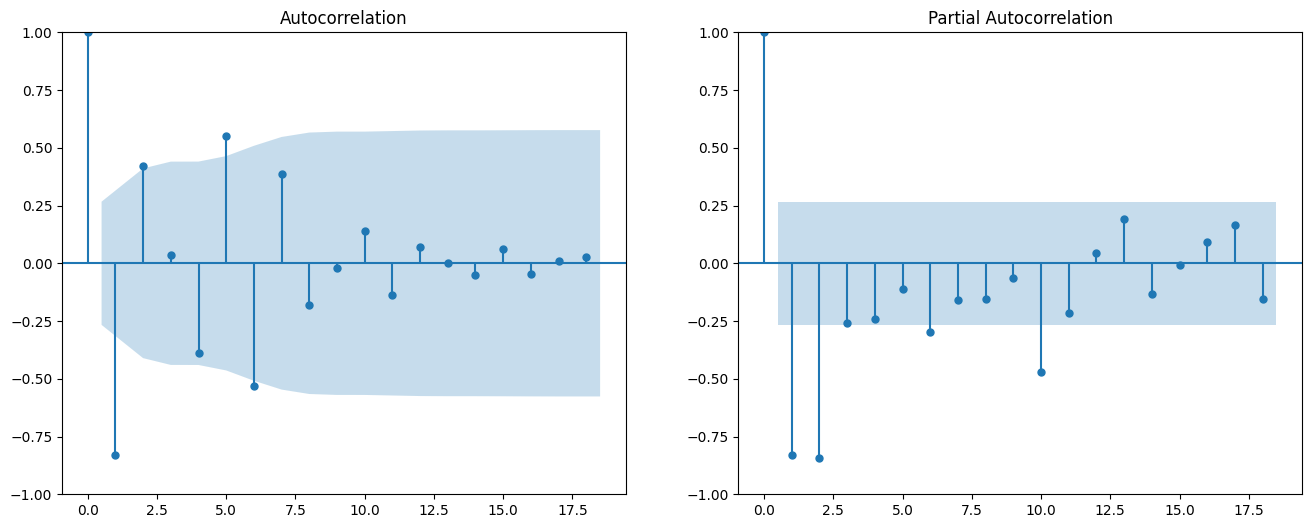

In [ ]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(pd.DataFrame(df_diff2).dropna(), ax=axes[0])
plot_pacf(pd.DataFrame(df_diff2).dropna(), ax=axes[1])
plt.show()

In [ ]:
SARIMA_model = pm.auto_arima(train["ROE"], start_p=1, start_q=1,
                         test='kpss',
                         max_p=5, max_q=5,
                         m=4, #12 is the frequncy of the cycle
                         start_P=1, start_Q=1,
                         max_P = 5, max_Q=5,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=None,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
SARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=270.051, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=200.431, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=238.006, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=411.401, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=205.848, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=201.372, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=267.668, Time=0.22 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=202.418, Time=0.31 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=202.424, Time=0.35 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=237.827, Time=0.39 sec
 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=203.600, Time=0.45 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 4)   Log Likelihood                 -96.215
Date:                           Thu, 18 Jul 2024   AIC                            200.431
Time:                                   15:06:52   BIC                            207.916
Sample:                                        0   HQIC                           203.260
                                            - 48                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0101      1.131      0.893      0.372      -1.207       3.227
ar.L1          0.9648      0.047     20.614      0.000       0.873       1.057
ar.S.L4       -0.4256      0.101     -4.204      0.000      -0.624      -0.227
sigma2         3.0400      0.441      6.897      0.000       2.176       3.904
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                15.16
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              15.28   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Best Model ARIMA(1, 0, 0)(1, 0, 0)[4]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


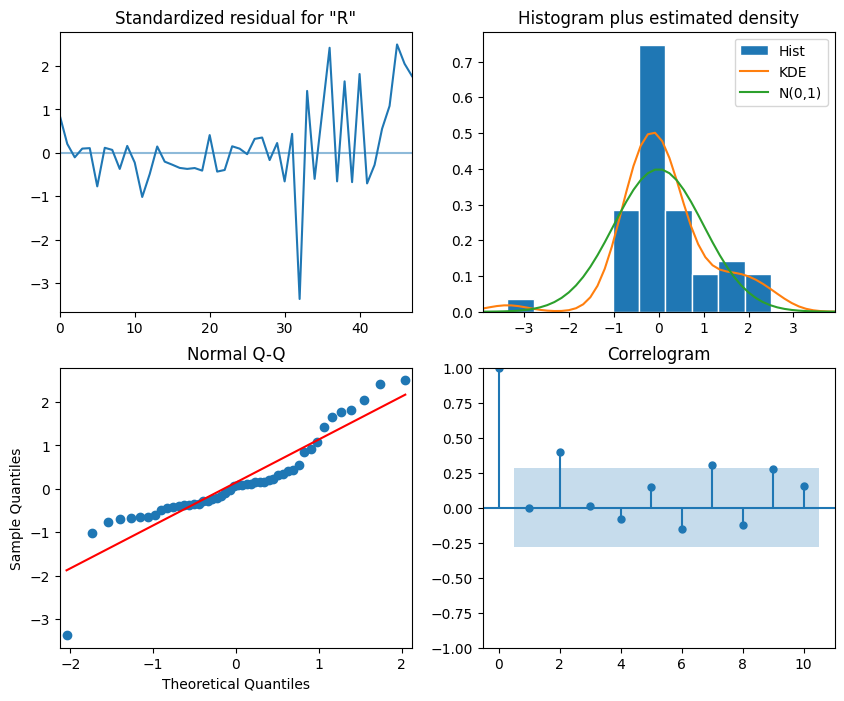

In [ ]:
SARIMA_model = SARIMAX(train["ROE"], order=(1,0,0), seasonal_order=(1,0,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.003223,0.954730
2,0.519200,0.771360
3,0.522642,0.913890
4,0.536386,0.969864
5,0.539882,0.990590
6,0.624523,0.995977
7,1.054247,0.993905
8,1.261342,0.995998
9,1.677187,0.995607
10,1.719303,0.998074


In [ ]:
# Predicting last 10 PEs of the data
SARIMA_pred = SARIMA_model_fit.get_prediction(l-10, l-1).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

<ipython-input-52-dbe47345b5e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


In [ ]:
# Fit GARCH model to the training set
garch_model = arch_model(train['ROE'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

In [ ]:
# Forecast using the GARCH model
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_pred = garch_forecast.mean.iloc[-1].values
test['GARCH_pred'] = garch_pred

<ipython-input-54-a0d20fe8156c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GARCH_pred'] = garch_pred


In [ ]:
# Fit ARMA model using pmdarima for automatic selection
arma_model = pm.auto_arima(train['ROE'],
                            test='kpss',
                            m=4,               # Seasonal frequency of series
                            seasonal=False,      # No presence of seasonality for standard ARIMA
                            d=None,             # Let the model determine 'd'
                            start_p=0, start_q=0, # Minimum p and q
                            max_p=2, max_q=2,   # Maximum p and q (example values, adjust as needed)
                            D=None,             # Let the model determine 'D'
                            trace=True,         # Print status on the console
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)      # Use stepwise algorithm for faster computation

arma_model.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=411.401, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=209.814, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=326.609, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=207.834, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=237.357, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=205.848, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=270.051, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=207.823, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=209.596, Time=0.13 sec

Best 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -99.924
Date:                Thu, 18 Jul 2024   AIC                            205.848
Time:                        15:07:49   BIC                            211.462
Sample:                             0   HQIC                           207.970
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1482      0.915      1.255      0.209      -0.645       2.941
ar.L1          0.9430      0.053     17.869      0.000       0.840       1.046
sigma2         3.5958      0.461      7.804      0.000       2.693       4.499
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                26.35
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):              17.40   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Get residuals from the ARMA model
residuals = arma_model.resid()

# Fit GARCH model to the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Forecast ARMA model
n_forecast = len(test)
arma_forecast, conf_int = arma_model.predict(n_periods=n_forecast, return_conf_int=True)

# Forecast GARCH model
garch_forecast = garch_fit.forecast(horizon=n_forecast)
garch_pred = garch_forecast.mean.iloc[-1].values

# Combine ARMA and GARCH forecasts
test['ARMA_GARCH_pred'] = arma_forecast + garch_pred

<ipython-input-56-e6f4f7f3b7e7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARMA_GARCH_pred'] = arma_forecast + garch_pred


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['ROE']])
test_scaled = scaler.transform(test[['ROE']])
test1 = df[-15:]
test1_scaled = scaler.transform(test1[['ROE']])

In [ ]:
# Create the dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 5
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)
X_test1, y_test1 = create_dataset(test1_scaled, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, 1)
X_test = X_test.reshape(X_test.shape[0], time_step, 1)
X_test1 = X_test1.reshape(X_test1.shape[0], time_step, 1)

In [ ]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
43/43 [==============================] - 5s 8ms/step - loss: 0.0554
Epoch 2/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0352
Epoch 3/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0287
Epoch 4/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0248
Epoch 5/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0264
Epoch 6/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0273
Epoch 7/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0241
Epoch 8/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0255
Epoch 9/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0251
Epoch 10/100
43/43 [==============================] - 0s 9ms/step - loss: 0.0235
Epoch 11/100
43/43 [==============================] - 0s 9ms/step - loss: 0.0217
Epoch 12/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 13/100
43/43 [=================

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test1)
# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

1/1 [==============================] - 0s 23ms/step


In [ ]:
test['LSTM_pred'] = test_predict[:, 0]

<ipython-input-62-feca5b1a0150>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM_pred'] = test_predict[:, 0]


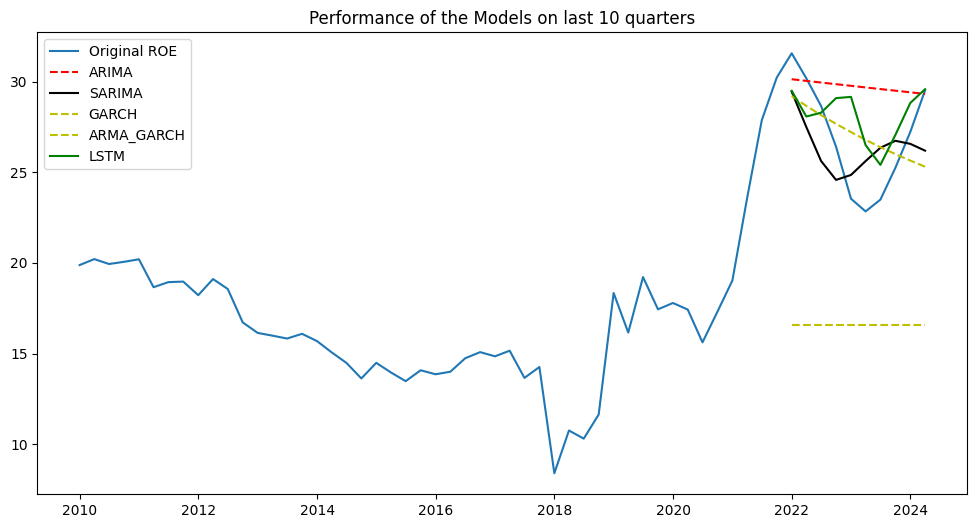

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'],df['ROE'], label='Original ROE')
plt.plot(df['Date'][-10:], test['ARIMA_pred'], 'r--', label='ARIMA')
plt.plot(df['Date'][-10:], test['SARIMA_pred'],  color = 'black', label='SARIMA')
plt.plot(df['Date'][-10:], test['GARCH_pred'],  'y--', label='GARCH')
plt.plot(df['Date'][-10:], test['ARMA_GARCH_pred'],  'y--', label='ARMA_GARCH')
plt.plot(df['Date'][-10:], test['LSTM_pred'],  color = 'green', label='LSTM')
plt.title('Performance of the Models on last 10 quarters')
plt.legend()
plt.show()

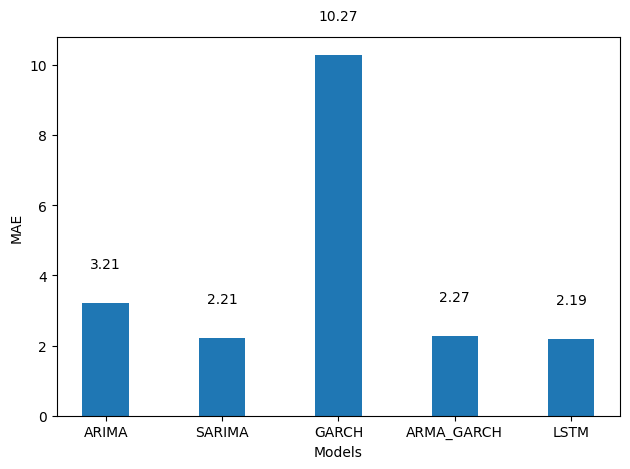

In [ ]:
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)))

mae_ARIMA = mae(test['ROE'], test['ARIMA_pred'])
mae_SARIMA = mae(test['ROE'], test['SARIMA_pred'])
mae_GARCH = mae(test['ROE'], test['GARCH_pred'])
mae_ARMA_GARCH = mae(test['ROE'], test['ARMA_GARCH_pred'])
mae_LSTM = mae(test['ROE'], test['LSTM_pred'])

fig, ax = plt.subplots()

x = ['ARIMA', 'SARIMA', 'GARCH', 'ARMA_GARCH', 'LSTM']
y = [mae_ARIMA, mae_SARIMA, mae_GARCH, mae_ARMA_GARCH, mae_LSTM]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()

1/1 [==============================] - 0s 211ms/step
Forecasted PE Ratios for the next 20 quarters:
[ 29.49165   24.814455  20.679583  19.424046  20.964296  24.468266
  28.466915  31.733742  32.458614  30.26742   27.513124  27.59755
  31.976244  41.550625  56.692684  75.21334   89.70619   93.30625
  96.19235  116.87044 ]


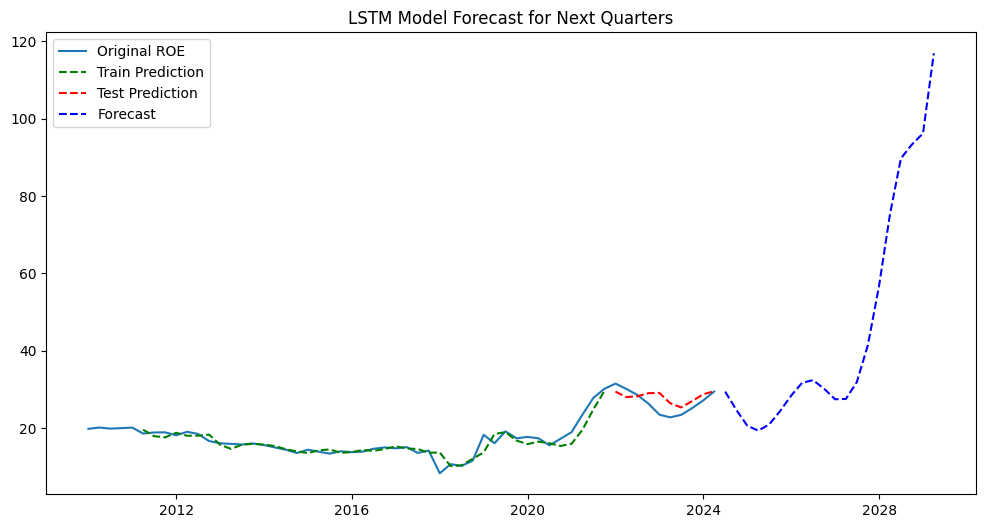

In [ ]:
# Forecasting the next n_steps quarters
n_steps = 20 # Number of steps to forecast
last_time_steps = train_scaled[-time_step:]  # Use the last time_step values from training set

forecasts = []
for i in range(n_steps):
    next_pred = model.predict(last_time_steps.reshape(1, time_step, 1))
    forecasts.append(next_pred[0, 0])
    last_time_steps = np.roll(last_time_steps, -1)
    last_time_steps[-1] = next_pred

# Invert forecasts to original scale
forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))

# Print and plot forecasts
print("Forecasted PE Ratios for the next", n_steps, "quarters:")
print(forecasts.flatten())

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['ROE'], label='Original ROE')
plt.plot(df['Date'][time_step:train_size], train_predict, 'g--', label='Train Prediction')
plt.plot(df['Date'][-10:], test_predict, 'r--', label='Test Prediction')
plt.plot(pd.date_range(df['Date'].iloc[-1], periods=n_steps+1, freq='Q')[1:], forecasts, 'b--', label='Forecast')
plt.title('LSTM Model Forecast for Next Quarters')
plt.legend()
plt.show()